<a href="https://colab.research.google.com/github/boringman21/btl_nlp/blob/main/NewDat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Dataset

### 1.1 Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 Unzip dataset

In [ ]:
zipped_path = '/content/drive/MyDrive/NewLeakDataset/Logger_Data_2024_Bau_Bang-2.zip'

!rm -rf LeakDataset
!unzip "$zipped_path" -d LeakDataset


Archive:  /content/drive/MyDrive/NewLeakDataset/Logger_Data_2024_Bau_Bang-2.zip
   creating: LeakDataset/Logger_Data_2024_Bau_Bang-2/
  inflating: LeakDataset/__MACOSX/._Logger_Data_2024_Bau_Bang-2  
  inflating: LeakDataset/Logger_Data_2024_Bau_Bang-2/find_query_3.csv  
  inflating: LeakDataset/__MACOSX/Logger_Data_2024_Bau_Bang-2/._find_query_3.csv  
  inflating: LeakDataset/Logger_Data_2024_Bau_Bang-2/find_query_2.csv  
  inflating: LeakDataset/__MACOSX/Logger_Data_2024_Bau_Bang-2/._find_query_2.csv  
  inflating: LeakDataset/Logger_Data_2024_Bau_Bang-2/Data note.docx  
  inflating: LeakDataset/__MACOSX/Logger_Data_2024_Bau_Bang-2/._Data note.docx  
  inflating: LeakDataset/Logger_Data_2024_Bau_Bang-2/find_query_1.csv  
  inflating: LeakDataset/__MACOSX/Logger_Data_2024_Bau_Bang-2/._find_query_1.csv  
  inflating: LeakDataset/Logger_Data_2024_Bau_Bang-2/channel_data_type.csv  
  inflating: LeakDataset/__MACOSX/Logger_Data_2024_Bau_Bang-2/._channel_data_type.csv  


In [ ]:
"""
Data loading and preprocessing functionality.
"""

import pandas as pd
import os

class DataLoader:
    def __init__(self, base_path):
        """
        Initialize DataLoader with the base path to data files.

        Args:
            base_path (str): Base directory containing the data files
        """
        self.base_path = base_path
        self.query_1_path = os.path.join(base_path, 'find_query_1.csv')
        self.query_2_path = os.path.join(base_path, 'find_query_2.csv')
        self.query_3_path = os.path.join(base_path, 'find_query_3.csv')
        self.channel_type_path = os.path.join(base_path, 'channel_data_type.csv')

    def load_all_data(self):
        """
        Load all CSV files and return as a dictionary of DataFrames.

        Returns:
            dict: Dictionary containing DataFrames for each data file
        """
        data = {
            'query_1': pd.read_csv(self.query_1_path),
            'query_2': pd.read_csv(self.query_2_path),
            'query_3': pd.read_csv(self.query_3_path),
            'channel_type': pd.read_csv(self.channel_type_path)
        }
        return data

    def preprocess_data(self, data):
        """
        Preprocess the loaded data.

        Args:
            data (dict): Dictionary of DataFrames

        Returns:
            pd.DataFrame: Preprocessed and merged DataFrame
        """
        # Add your preprocessing steps here
        # This is a placeholder for your specific preprocessing logic
        pass


In [ ]:
data_loader = DataLoader('/content/LeakDataset/Logger_Data_2024_Bau_Bang-2')
data = data_loader.load_all_data()

### 1.3 Define Data path

In [ ]:
base_path = '/content/LeakDataset/Logger_Data_2024_Bau_Bang-2'
query_1_path = f'{base_path}/find_query_1.csv'
query_2_path = f'{base_path}/find_query_2.csv'
query_3_path = f'{base_path}/find_query_3.csv'
channel_type_path = f'{base_path}/channel_data_type.csv'


## 2.Ultility func

In [ ]:
import gc
import psutil
import os

# Enable garbage collection (default is enabled, but just in case)
gc.enable()

def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 * 1024):.2f} MB")  # Convert bytes to MB

print_memory_usage()  # Call before and after GC
gc.collect()
print_memory_usage()

Memory Usage: 768.96 MB
Memory Usage: 768.96 MB


### 2.1 Get csv df

### 2.2 Get all file df

In [ ]:
import pandas as pd

query_1_df = pd.read_csv(query_1_path)
query_2_df = pd.read_csv(query_3_path)
query_3_df = pd.read_csv(query_3_path)

channel_type_df = pd.read_csv(channel_type_path)

### 2.3 Get merged data df

In [ ]:
# Concatenating the DataFrames row-wise
merged_df = pd.concat([query_1_df, query_2_df, query_3_df], ignore_index=True)

### 2.4 Transform merged data df

In [ ]:
import pandas as pd
import numpy as np


def transform_df(df):
    # Drop specified columns
    columns_to_drop = ['_id', 'count', 'sum', 'average', 'min', 'max',
                      'startDate', 'endDate', 'lastDataUpdateTime', 'dataType']
    df = df.drop(columns=columns_to_drop, errors='ignore')


    # Define column mapping based on chNumber
    ch_map = {0: '_Pressure_1', 1: '_Flow', 2: '_Pressure_2'}

    # Generate column names for timestamps and values
    time_cols = np.array([f'dataValues.{i}.dataTime' for i in range(96)])
    value_cols = np.array([f'dataValues.{i}.dataValue' for i in range(96)])

    # Filter valid chNumber values
    df = df[df['chNumber'].isin(ch_map.keys())].copy()

    # Create column names using vectorized operations
    df['col_name'] = df['smsNumber'].astype(str) + df['chNumber'].map(ch_map)

    # Convert DataFrame to NumPy arrays for faster processing
    timestamps = df[time_cols].to_numpy()  # Shape: (n_rows, 96)
    values = df[value_cols].to_numpy()     # Shape: (n_rows, 96)
    col_names = df['col_name'].to_numpy()  # Shape: (n_rows,)

    # Reshape into long format using NumPy
    n_rows = len(df)
    timestamps_flat = timestamps.reshape(n_rows * 96)  # Shape: (n_rows * 96,)
    values_flat = values.reshape(n_rows * 96)          # Shape: (n_rows * 96,)
    col_names_flat = np.repeat(col_names, 96)          # Shape: (n_rows * 96,)

    # Create a single DataFrame with all data
    long_df = pd.DataFrame({
        'Timestamp': timestamps_flat,
        'Value': values_flat,
        'Column': col_names_flat
    })

    # Filter out invalid rows (NaN timestamps or values)
    # long_df = long_df[long_df['Timestamp'].notna() & long_df['Value'].notna()]
    long_df = long_df[long_df['Timestamp'].notna()]

    # Pivot the data efficiently
    result_df = long_df.pivot_table(
        index='Timestamp',
        columns='Column',
        values='Value',
        aggfunc='first'  # Use 'mean' or 'last' if preferred
    ).reset_index()

    # Sort by timestamp
    result_df = result_df.sort_values('Timestamp').reset_index(drop=True)

    return result_df

# Apply transformation
result_df = transform_df(merged_df)
# result_df.to_csv('/content/drive/MyDrive/NewLeakDataset/data_df.csv')


### 2.5 Get sensor ids having 3 metrics

In [ ]:
def get_sensor_ids(result_df):
    filtered_columns = result_df.columns[result_df.columns.str.endswith('_Pressure_2')]
    sensor_ids = [col.split('_')[0] for col in filtered_columns]
    return sensor_ids

def filter_pressure_2_columns(result_df):
    sensor_ids = get_sensor_ids(result_df)

    cols = ['Timestamp']

    for sensor_id in sensor_ids[:-3]:
        flow_col = f'{sensor_id}_Flow'
        pressure_1_col = f'{sensor_id}_Pressure_1'
        pressure_2_col = f'{sensor_id}_Pressure_2'

        cols.append(flow_col)
        cols.append(pressure_1_col)
        cols.append(pressure_2_col)

    new_df = result_df[cols]
    return new_df


### 2.6 Visualize sensor data having 3 metrics

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_flow_and_pressure(result_df, sensor_id):
    """
    Plots flow and pressure data from the given DataFrame for the specified sensor ID.
    Saves the plots to "NewDataVisualization/{sensor_id}" folder.
    Dynamically visualizes columns based on their presence.

    Parameters:
        result_df (pd.DataFrame): DataFrame containing 'Timestamp', 'Flow', 'Pressure_1', and 'Pressure_2' columns.
        sensor_id (str or int): The sensor ID to filter the columns.
    """
    sensor_id = str(sensor_id)
    flow_col = f'{sensor_id}_Flow'
    pressure_1_col = f'{sensor_id}_Pressure_1'
    pressure_2_col = f'{sensor_id}_Pressure_2'
    timestamp_col = 'Timestamp'

    # Create directory structure "NewDataVisualization/{sensor_id}"
    folder_path = f"/content/drive/MyDrive/NewDataVisualization/{sensor_id}"
    os.makedirs(folder_path, exist_ok=True)

    # Check if the timestamp column exists
    if timestamp_col not in result_df.columns:
        print(f"Error: Missing '{timestamp_col}' column in DataFrame.")
        return

    # Convert Timestamp to datetime
    result_df[timestamp_col] = pd.to_datetime(result_df[timestamp_col])

    # Initialize the plot
    plt.figure(figsize=(12, 10))

    plot_count = 1

    # Plot Flow if available
    if flow_col in result_df.columns:
        plt.subplot(4, 1, plot_count)
        plt.plot(result_df[timestamp_col], result_df[flow_col], label='Flow', color='blue')
        plt.title(f'Flow vs Time (Sensor {sensor_id})')
        plt.xlabel('Timestamp')
        plt.ylabel('Flow')
        plt.grid(True)
        plt.legend()
        plot_count += 1

    # Plot Pressure_1 if available
    if pressure_1_col in result_df.columns:
        plt.subplot(4, 1, plot_count)
        plt.plot(result_df[timestamp_col], result_df[pressure_1_col], label='Pressure_1', color='green')
        plt.title(f'Pressure_1 vs Time (Sensor {sensor_id})')
        plt.xlabel('Timestamp')
        plt.ylabel('Pressure_1')
        plt.grid(True)
        plt.legend()
        plot_count += 1

    # Plot Pressure_2 if available
    if pressure_2_col in result_df.columns:
        plt.subplot(4, 1, plot_count)
        plt.plot(result_df[timestamp_col], result_df[pressure_2_col], label='Pressure_2', color='red')
        plt.title(f'Pressure_2 vs Time (Sensor {sensor_id})')
        plt.xlabel('Timestamp')
        plt.ylabel('Pressure_2')
        plt.grid(True)
        plt.legend()
        plot_count += 1

    # Plot Pressure Difference if both Pressure_1 and Pressure_2 are available
    if pressure_1_col in result_df.columns and pressure_2_col in result_df.columns:
        result_df['Pressure_Diff'] = result_df[pressure_2_col] - result_df[pressure_1_col]
        plt.subplot(4, 1, plot_count)
        plt.plot(result_df[timestamp_col], result_df['Pressure_Diff'], label='Pressure_2 - Pressure_1', color='purple')
        plt.title(f'Pressure Difference (Pressure_2 - Pressure_1) vs Time (Sensor {sensor_id})')
        plt.xlabel('Timestamp')
        plt.ylabel('Pressure Difference')
        plt.grid(True)
        plt.legend()
        plot_count += 1

    # Adjust layout and save the plot if any plot was created
    if plot_count > 1:
        plt.tight_layout()
        save_path = os.path.join(folder_path, f"sensor_{sensor_id}_plot.png")
        plt.savefig(save_path)
        plt.close()
        print(f"Plot saved to {save_path}")
    else:
        print("No valid data to plot.")


In [ ]:
sensor_ids = get_sensor_ids(result_df)
print(len(sensor_ids))

for sensor in sensor_ids:
    plot_flow_and_pressure(result_df, sensor)

9
Plot saved to /content/drive/MyDrive/NewDataVisualization/8401210607558/sensor_8401210607558_plot.png
Plot saved to /content/drive/MyDrive/NewDataVisualization/840786560116/sensor_840786560116_plot.png
Plot saved to /content/drive/MyDrive/NewDataVisualization/841210607378/sensor_841210607378_plot.png
Plot saved to /content/drive/MyDrive/NewDataVisualization/841210620665/sensor_841210620665_plot.png
Plot saved to /content/drive/MyDrive/NewDataVisualization/841210802047/sensor_841210802047_plot.png
Plot saved to /content/drive/MyDrive/NewDataVisualization/841210802048/sensor_841210802048_plot.png
Plot saved to /content/drive/MyDrive/NewDataVisualization/841211914190/sensor_841211914190_plot.png
Plot saved to /content/drive/MyDrive/NewDataVisualization/841212383325/sensor_841212383325_plot.png
Plot saved to /content/drive/MyDrive/NewDataVisualization/84797805118/sensor_84797805118_plot.png


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(result_df, sensor_id):
    """
    Plots the correlation matrix of flow and pressure data for the specified sensor ID.
    Saves the plots to "NewDataVisualization/{sensor_id}" folder.

    Parameters:
        result_df (pd.DataFrame): DataFrame containing 'Flow', 'Pressure_1', and 'Pressure_2' columns.
        sensor_id (str or int): The sensor ID to filter the columns.
    """
    sensor_id = str(sensor_id)
    flow_col = f'{sensor_id}_Flow'
    pressure_1_col = f'{sensor_id}_Pressure_1'
    pressure_2_col = f'{sensor_id}_Pressure_2'

    # Create directory structure "NewDataVisualization/{sensor_id}"
    folder_path = f"/content/drive/MyDrive/NewDataVisualization/{sensor_id}"
    os.makedirs(folder_path, exist_ok=True)

    # Check if required columns exist
    required_cols = [flow_col, pressure_1_col, pressure_2_col]
    missing_cols = [col for col in required_cols if col not in result_df.columns]
    if missing_cols:
        print(f"Error: Missing columns in DataFrame: {', '.join(missing_cols)}")
        return

    # Extract relevant columns
    df = result_df[[flow_col, pressure_1_col, pressure_2_col]]

    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title(f'Correlation Matrix (Sensor {sensor_id})')

    # Save the plot to the specified folder
    save_path = os.path.join(folder_path, f"sensor_{sensor_id}_correlation.png")
    plt.savefig(save_path)
    plt.close()
    print(f"Correlation plot saved to {save_path}")


In [ ]:
for sensor in sensor_ids:
    plot_correlation(result_df, sensor)

Correlation plot saved to /content/drive/MyDrive/NewDataVisualization/8401210607558/sensor_8401210607558_correlation.png
Correlation plot saved to /content/drive/MyDrive/NewDataVisualization/840786560116/sensor_840786560116_correlation.png
Correlation plot saved to /content/drive/MyDrive/NewDataVisualization/841210607378/sensor_841210607378_correlation.png
Correlation plot saved to /content/drive/MyDrive/NewDataVisualization/841210620665/sensor_841210620665_correlation.png
Correlation plot saved to /content/drive/MyDrive/NewDataVisualization/841210802047/sensor_841210802047_correlation.png
Correlation plot saved to /content/drive/MyDrive/NewDataVisualization/841210802048/sensor_841210802048_correlation.png
Correlation plot saved to /content/drive/MyDrive/NewDataVisualization/841211914190/sensor_841211914190_correlation.png
Correlation plot saved to /content/drive/MyDrive/NewDataVisualization/841212383325/sensor_841212383325_correlation.png
Error: Missing columns in DataFrame: 847978051

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def fourier_approximation(t, y, num_terms=10):
    """
    Computes Fourier approximation of y(t) using num_terms terms.
    """
    n = len(y)
    a0 = np.mean(y)
    approx = np.full_like(t, a0)

    for k in range(1, num_terms + 1):
        ak = np.sum(y * np.cos(k * t)) * 2 / n
        bk = np.sum(y * np.sin(k * t)) * 2 / n
        approx += ak * np.cos(k * t) + bk * np.sin(k * t)

    return approx


def plot_fourier_approximation(timestamps, values, label, sensor_id, folder_path, color='blue', num_terms=10):
    """
    Plots and saves original data vs. its Fourier approximation.

    Parameters:
        timestamps (pd.Series): Timestamps for x-axis.
        values (np.array): Original y values.
        label (str): Label for the signal (e.g., 'Flow').
        sensor_id (str): Sensor ID.
        folder_path (str): Where to save the plot.
        color (str): Color for the original line.
        num_terms (int): Number of terms in Fourier approximation.
    """
    n = len(values)
    t_numeric = np.linspace(0, 2 * np.pi, n)
    approx = fourier_approximation(t_numeric, values, num_terms=num_terms)

    plt.figure(figsize=(12, 4))
    plt.plot(t_numeric, values, label=f'{label} (original)', color=color, alpha=0.6)
    plt.plot(t_numeric, approx, label=f'{label} (Fourier approx)', color='black', linestyle='--')
    plt.title(f'{label} with Fourier Approximation (Sensor {sensor_id})')
    plt.xlabel('Normalized Time')
    plt.ylabel(label)
    plt.grid(True)
    plt.legend()

    # Save and show plot
    save_path = os.path.join(folder_path, f'{sensor_id}_{label}_fourier.png')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"Fourier approximation plot saved to {save_path}")



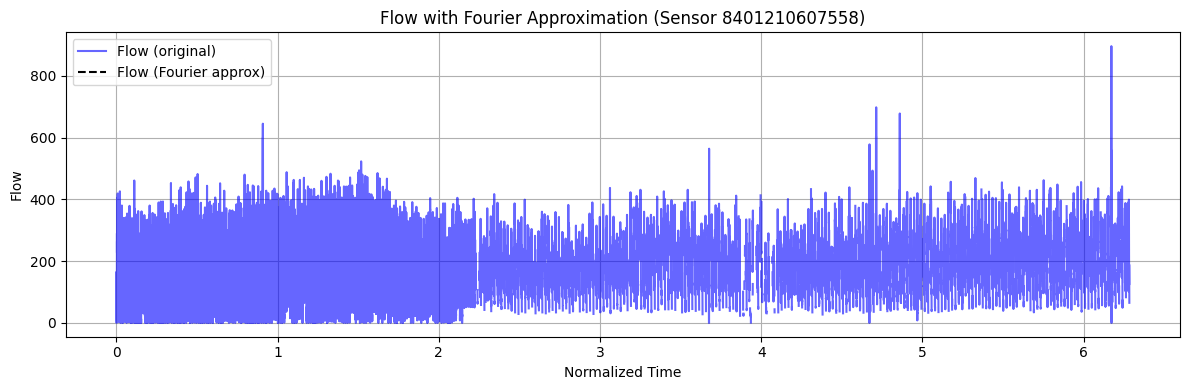

Fourier approximation plot saved to 8401210607558_Flow_fourier.png


In [ ]:
for sensor in sensor_ids:
    # plot_correlation(result_df, sensor)

    flow_col = f'{sensor}_Flow'
    timestamp_col = 'Timestamp'
    pressure_1_col = f'{sensor}_Pressure_1'
    pressure_2_col = f'{sensor}_Pressure_2'
    # plot_with_fourier(flow_col, 'Flow', 'blue', 'Flow')
    plot_fourier_approximation(
        result_df[timestamp_col],
        result_df[flow_col].values,
        'Flow',
        sensor,
        '',
        color='blue'
    )

    break

# if flow_col in result_df.columns:
#     plot_with_fourier(flow_col, 'Flow', 'blue', 'Flow')
#     plot_fourier_approximation(
#         result_df[timestamp_col],
#         result_df[flow_col].values,
#         'Flow',
#         sensor_id,
#         folder_path,
#         color='blue'
#     )


## 3.EDA


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

class EDA:
    def __init__(self, df, sms_list):
        self.df = df
        self.sms_list = sms_list

    def preprocess_data(self):
        # Xử lý missing data
        for sms in self.sms_list:
            # Interpolation cho các giá trị Flow
            self.df[f'{sms}_Flow'] = self.df[f'{sms}_Flow'].interpolate(method='time')

            # Forward fill cho Pressure
            for p in ['Pressure_1', 'Pressure_2']:
                self.df[f'{sms}_{p}'] = self.df[f'{sms}_{p}'].fillna(method='ffill')

        # Phát hiện và xử lý outliers
        def remove_outliers(col):
            q1 = col.quantile(0.25)
            q3 = col.quantile(0.75)
            iqr = q3 - q1
            return col.clip(lower=q1 - 1.5 * iqr, upper=q3 + 1.5 * iqr)

        for sms in self.sms_list:
            self.df[f'{sms}_Flow'] = remove_outliers(self.df[f'{sms}_Flow'])

        return self.df

    def analyze_time_series(self, sms):
        # Resample theo daily
        daily_flow = self.df[f'{sms}_Flow'].resample('D').mean()

        # Tính toán tương quan
        pressure_diff = self.df[f'{sms}_Pressure_1'] - self.df[f'{sms}_Pressure_2']
        correlation = self.df[f'{sms}_Flow'].corr(pressure_diff)

        # Phân tích hourly pattern
        hourly_pattern = self.df.groupby(self.df.index.hour)[f'{sms}_Flow'].mean()

        return {
            'daily_flow': daily_flow,
            'pressure_correlation': correlation,
            'hourly_pattern': hourly_pattern
        }

    def pressure_drop_analysis(self, sms, threshold=0.5):
        self.df[f'{sms}_Pressure_diff'] = self.df[f'{sms}_Pressure_1'] - self.df[f'{sms}_Pressure_2']
        abnormal_drop = self.df[(self.df[f'{sms}_Pressure_diff'] > threshold) & \
                              (self.df[f'{sms}_Flow'] < self.df[f'{sms}_Flow'].quantile(0.1))]

        plt.scatter(self.df[f'{sms}_Flow'], self.df[f'{sms}_Pressure_diff'])
        plt.title(f'Pressure Drop vs Flow - {sms}')
        plt.xlabel('Flow Rate')
        plt.ylabel('Pressure Difference')
        plt.show()

        return abnormal_drop

    def detect_anomalies(self, sms):
        anomalies = pd.DataFrame(index=self.df.index)
        night_mask = (self.df.index.hour >= 1) & (self.df.index.hour <= 4)
        anomalies['leak'] = (self.df[night_mask][f'{sms}_Flow'] > self.df[f'{sms}_Flow'].quantile(0.95)) & \
                            (self.df[night_mask][f'{sms}_Pressure_diff'].diff().abs() > 0.3)
        # anomalies['blockage'] = (self.df[f'{sms}_Pressure_diff'].rolling('4H').std() > 0.5) & \
        #                        (self.df[f'{sms}_Flow'].diff().abs() < 0.1)
        pressure_negative = self.df[f'{sms}_Pressure_1'] < self.df[f'{sms}_Pressure_2']
        constant_values = (self.df[f'{sms}_Flow'].rolling('24H').std() == 0) | \
                          (self.df[f'{sms}_Pressure_1'].rolling('24H').std() == 0)
        anomalies['sensor_fault'] = pressure_negative | constant_values

        return anomalies

    def calculate_performance(self, sms):
        avg_pressure_diff = self.df[f'{sms}_Pressure_diff'].mean()
        max_flow = self.df[f'{sms}_Flow'].max()
        min_flow = self.df[f'{sms}_Flow'].min()
        night_flow = self.df.between_time('1:00', '4:00')[f'{sms}_Flow'].mean()
        nrw = (night_flow / self.df[f'{sms}_Flow'].mean()) * 100

        return {
            'avg_pressure_diff': avg_pressure_diff,
            'flow_variability': (max_flow - min_flow) / max_flow,
            'nrw_percent': nrw
        }

    def forecast_flow(self, sms, steps=96):
        model = ARIMA(self.df[f'{sms}_Flow'], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=steps)
        return forecast


In [ ]:
print(result_df.info())

result_df['Timestamp'] = pd.to_datetime(result_df['Timestamp'])
result_df.set_index('Timestamp', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47555 entries, 0 to 47554
Columns: 306 entries, Timestamp to 84844267616_Pressure_1
dtypes: float64(305), object(1)
memory usage: 111.0+ MB
None


<ipython-input-110-f570e4a2bff0>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df[f'{sms}_{p}'] = self.df[f'{sms}_{p}'].fillna(method='ffill')
<ipython-input-110-f570e4a2bff0>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df[f'{sms}_{p}'] = self.df[f'{sms}_{p}'].fillna(method='ffill')
<ipython-input-110-f570e4a2bff0>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df[f'{sms}_{p}'] = self.df[f'{sms}_{p}'].fillna(method='ffill')
<ipython-input-110-f570e4a2bff0>:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df[f'{sms}_{p}'] = self.df[f'{sms}_{p}'].fillna(method='ffill')
<ipython-input-110-f570e4a2bff0>:22:

Dữ liệu sau tiền xử lý: Column                     8401210607558_Flow  8401210607558_Pressure_1  \
Timestamp                                                                 
2024-01-01 00:00:00+00:00                62.0                     446.0   
2024-01-01 00:15:00+00:00                42.0                     449.0   
2024-01-01 00:30:00+00:00                42.0                     445.0   
2024-01-01 00:45:00+00:00                37.0                     451.0   
2024-01-01 01:00:00+00:00                37.0                     450.0   

Column                     8401210607558_Pressure_2  8401210607648_Flow  \
Timestamp                                                                 
2024-01-01 00:00:00+00:00                     251.0                10.0   
2024-01-01 00:15:00+00:00                     252.0                 8.0   
2024-01-01 00:30:00+00:00                     251.0                 8.0   
2024-01-01 00:45:00+00:00                     252.0                 8.0   


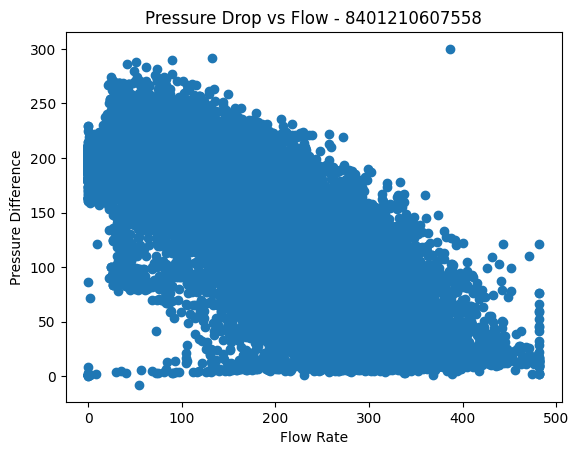

Mất áp bất thường: Column                     8401210607558_Flow  8401210607558_Pressure_1  \
Timestamp                                                                 
2024-01-01 01:30:00+00:00                16.0                     455.0   
2024-01-01 01:45:00+00:00                10.0                     452.0   
2024-01-01 02:00:00+00:00                23.0                     454.0   
2024-01-01 02:30:00+00:00                27.0                     455.0   
2024-01-01 02:45:00+00:00                 5.0                     456.0   
...                                       ...                       ...   
2024-12-26 13:45:00+00:00                 0.0                      -4.0   
2024-12-26 14:00:00+00:00                 0.0                      -2.0   
2024-12-26 14:15:00+00:00                 0.0                      -1.0   
2024-12-26 14:30:00+00:00                 0.0                       0.0   
2024-12-29 03:00:00+00:00                30.0                     444.0   

Colum

<ipython-input-110-f570e4a2bff0>:71: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomalies['blockage'] = (self.df[f'{sms}_Pressure_diff'].rolling('4H').std() > 0.5) & \
<ipython-input-110-f570e4a2bff0>:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  constant_values = (self.df[f'{sms}_Flow'].rolling('24H').std() == 0) | \
<ipython-input-110-f570e4a2bff0>:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  (self.df[f'{sms}_Pressure_1'].rolling('24H').std() == 0)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provid

Dự báo lưu lượng: 47555    67.651648
47556    68.086357
47557    67.904118
47558    67.693937
47559    67.692206
           ...    
47646    67.735227
47647    67.735227
47648    67.735227
47649    67.735227
47650    67.735227
Name: predicted_mean, Length: 96, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:

# Khởi tạo đối tượng EDA
eda = EDA(result_df, sensor_ids[:-1])

# Tiền xử lý dữ liệu
df_clean = eda.preprocess_data()
print('Dữ liệu sau tiền xử lý:', df_clean.head())

# Phân tích chuỗi thời gian
sms = sensor_ids[0]
analysis_results = eda.analyze_time_series(sms)
print('Phân tích chuỗi thời gian:', analysis_results)

# Phân tích mất áp
abnormal_drops = eda.pressure_drop_analysis(sms)
print('Mất áp bất thường:', abnormal_drops)

# Phát hiện sự cố
anomalies = eda.detect_anomalies(sms)
print('Sự cố phát hiện được:', anomalies)

# Đánh giá hiệu suất
performance = eda.calculate_performance(sms)
print('Hiệu suất:', performance)

# Dự báo lưu lượng
forecast = eda.forecast_flow(sms)
print('Dự báo lưu lượng:', forecast)


## 4.Model


In [ ]:
def create_dataset(data, window_hours=6, freq_minutes=15):
    """
    Tạo dataset để dự đoán giá trị tiếp theo (tick kế tiếp)
    dựa trên cửa sổ thời gian trước đó

    Parameters:
    - data: Mảng numpy chứa dữ liệu (flow, pressure...)
    - window_hours: Số giờ dùng để dự đoán (mặc định 6 giờ)
    - freq_minutes: Tần suất sampling dữ liệu (phút, mặc định 15 phút)

    Returns:
    - X: Các cửa sổ thời gian (shape: [samples, window_size, features])
    - y: Giá trị ngay sau cửa sổ (shape: [samples, features])
    """
    # Tính số samples trong window (làm tròn xuống)
    window_size = int((window_hours * 60) // freq_minutes)

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])  # Lấy giá trị ngay tiếp theo

    return np.array(X), np.array(y)

In [ ]:
for sensor_id in sensor_ids:
    flow_col, pressure_1_col, pressure_2_col = f'{sensor_id}_Flow', f'{sensor_id}_Pressure_1', f'{sensor_id}_Pressure_2'

    features = result_df[[flow_col, pressure_1_col, pressure_2_col]].values
    features['Delta_P'] = features[pressure_1_col] - features[pressure_2_col]


    X, y = create_dataset(features)


In [ ]:
import pandas as pd

# Giả sử bạn có dataframe với cột timestamp tên là 'Timestamp'
# Ví dụ:
# df = pd.DataFrame({
#     'Timestamp': [
#         '2025-04-08 00:00:00',
#         '2025-04-08 00:15:00',
#         '2025-04-08 00:30:00',
#         '2025-04-08 01:00:00'  # Thiếu 00:45:00
#     ]
# })

df = result_df.copy()

# B1: Convert Timestamp về datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# B2: Sắp xếp theo thời gian
df = df.sort_values('Timestamp')

# B3: Tạo dãy thời gian chuẩn cách nhau 15 phút
start = df['Timestamp'].min()
print(start)
end = df['Timestamp'].max()
print(end)
full_range = pd.date_range(start=start, end=end, freq='15T')

# B4: So sánh
actual_timestamps = df['Timestamp']
missing = full_range.difference(actual_timestamps)

print("Các timestamp bị thiếu:")
print(missing)


2024-01-01 00:00:00+00:00
2024-12-31 23:45:00+00:00
Các timestamp bị thiếu:
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='15min')


<ipython-input-47-3d83e139f275>:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=start, end=end, freq='15T')


<ipython-input-27-e449c76a89b7>:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('15T').mean().interpolate()
<ipython-input-27-e449c76a89b7>:30: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['night_flow'] = df['8401210607558_Flow'].between_time('1:00', '4:00').resample('15T').mean()
<ipython-input-27-e449c76a89b7>:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['flow_rolling_std'] = df['8401210607558_Flow'].rolling('6H').std()


Column                     8401210607558_Pressure_1  8401210607558_Pressure_2  \
Timestamp                                                                       
2024-01-01 00:00:00+00:00                     446.0                     251.0   
2024-01-01 00:15:00+00:00                     449.0                     252.0   
2024-01-01 00:30:00+00:00                     445.0                     251.0   
2024-01-01 00:45:00+00:00                     451.0                     252.0   
2024-01-01 01:00:00+00:00                     450.0                     252.0   
...                                             ...                       ...   
2024-12-31 22:45:00+00:00                     462.0                     243.0   
2024-12-31 23:00:00+00:00                     471.0                     244.0   
2024-12-31 23:15:00+00:00                     467.0                     244.0   
2024-12-31 23:30:00+00:00                     464.0                     244.0   
2024-12-31 23:45:00+00:00   

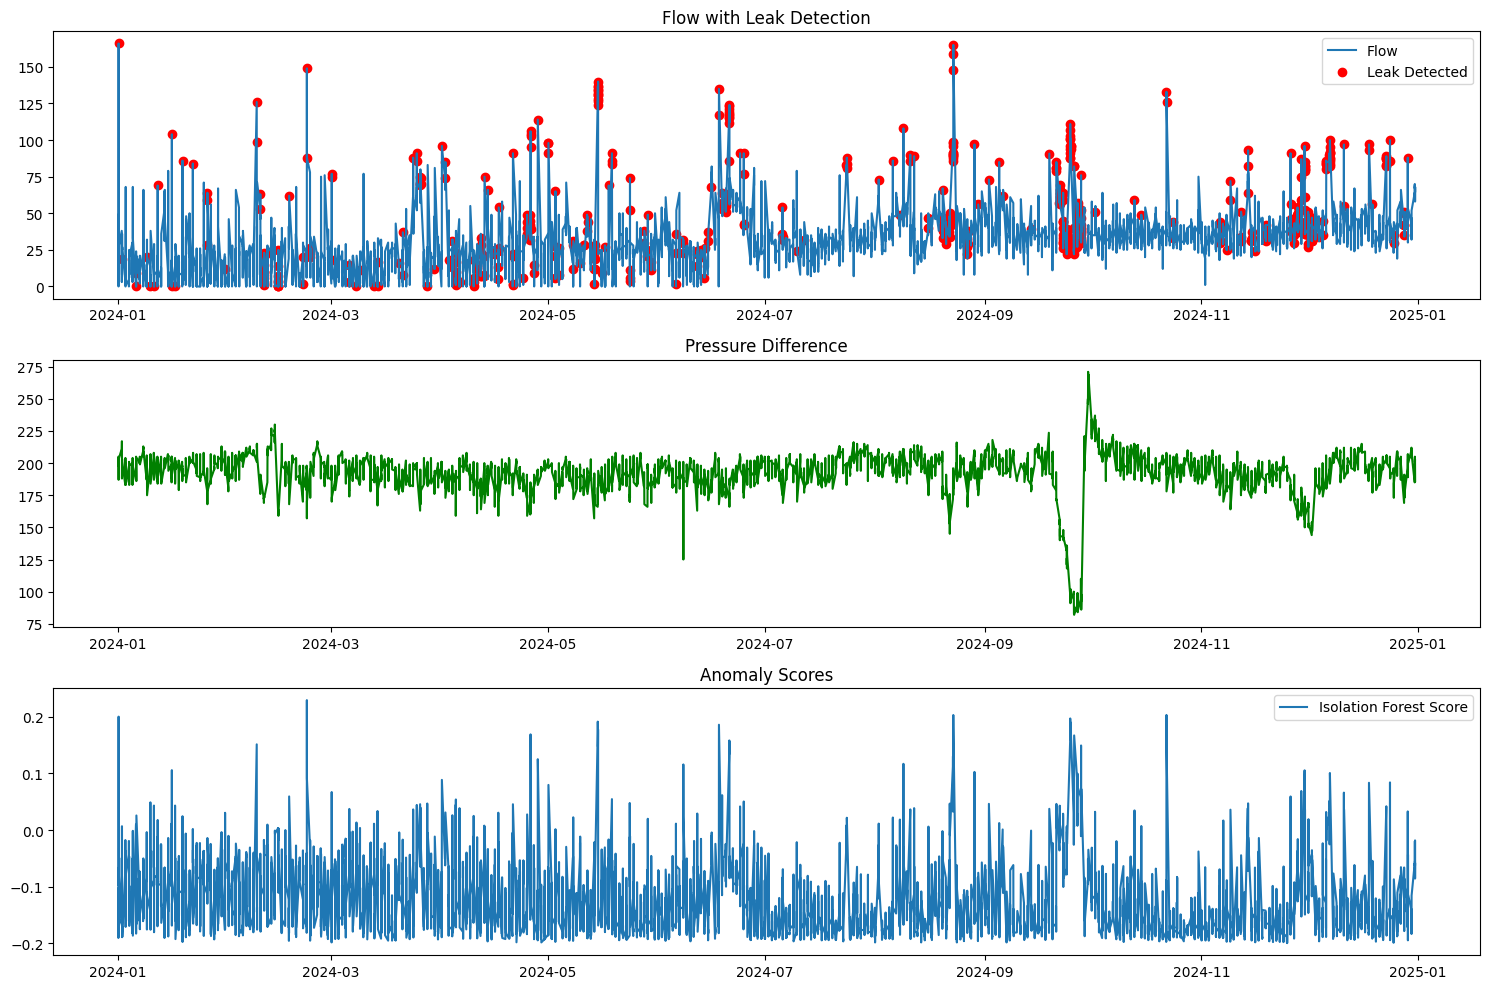

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# 1. Load và tiền xử lý dữ liệu
def load_data(result_df):
    df = result_df.copy()[['Timestamp', '8401210607558_Pressure_1', '8401210607558_Pressure_2', '8401210607558_Flow']]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp').sort_index()

    # Tính toán Pressure Difference
    df['Delta_P'] = df['8401210607558_Pressure_1'] - df['8401210607558_Pressure_2']

    # Resample nếu cần (đảm bảo đều đặn 15 phút)
    df = df.resample('15T').mean().interpolate()
    return df

# 2. Tính toán các đặc trưng rò rỉ
def extract_leak_features(df):
    # Đặc trưng thời gian
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday

    # Đặc trưng vật lý
    df['flow_pressure_ratio'] = df['8401210607558_Flow'] / (df['Delta_P'] + 1e-6)
    df['night_flow'] = df['8401210607558_Flow'].between_time('1:00', '4:00').resample('15T').mean()

    # Đặc trưng thống kê
    df['flow_rolling_std'] = df['8401210607558_Flow'].rolling('6H').std()
    df['pressure_diff_change'] = df['Delta_P'].diff().abs()

    return df.dropna()

# 3. Phát hiện rò rỉ bằng Isolation Forest
def detect_leaks_with_isolation_forest(df, contamination=0.05):
    features = df[['8401210607558_Flow', 'Delta_P', 'night_flow',
                  'flow_pressure_ratio', 'pressure_diff_change']]

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    model = IsolationForest(contamination=contamination, random_state=42)
    df['leak_pred'] = model.fit_predict(scaled_features)
    df['leak_score'] = -model.decision_function(scaled_features)

    return df

# 4. Mô hình LSTM phát hiện bất thường
def build_lstm_autoencoder(input_shape):
    model = Sequential([
        LSTM(32, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(16, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(input_shape[0])
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_with_lstm(df, window_hours=12):
    # Chuẩn bị dữ liệu
    data = df[['8401210607558_Flow', 'Delta_P']].values
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Tạo cửa sổ thời gian
    window_size = int(window_hours * 4)  # 15 phút * 12h
    X = np.array([scaled_data[i:i+window_size] for i in range(len(data)-window_size)])
    print(X)
    print(X.shape)

    # Huấn luyện autoencoder
    model = build_lstm_autoencoder((window_size, 2))
    model.fit(X, X, epochs=20, batch_size=32, validation_split=0.1)

    # Tính reconstruction error
    pred = model.predict(X)
    mse = np.mean(np.square(pred - X), axis=1)
    df['lstm_anomaly_score'] = pd.Series(mse, index=df.index[window_size:])

    return df

# 5. Kết hợp tất cả phương pháp
def combined_leak_detection(df):
    # Ngưỡng vật lý cơ bản
    df['physical_leak'] = ((df['8401210607558_Flow'] > 0) &
                          (df['hour'].between(1, 4)) &
                          (df['Delta_P'] < df['Delta_P'].quantile(0.1)))

    # Isolation Forest
    df = detect_leaks_with_isolation_forest(df)

    # LSTM Autoencoder
    # df = detect_with_lstm(df)

    # Kết hợp kết quả
    df['final_leak_flag'] = (df['physical_leak']) | (df['leak_pred'] == -1)

    return df

# 6. Visualize kết quả
def plot_leak_results(df):
    fig, ax = plt.subplots(3, 1, figsize=(15, 10))

    # Plot Flow và leak points
    ax[0].plot(df.index, df['8401210607558_Flow'], label='Flow')
    ax[0].scatter(df[df['final_leak_flag']].index,
                 df[df['final_leak_flag']]['8401210607558_Flow'],
                 color='red', label='Leak Detected')
    ax[0].set_title('Flow with Leak Detection')
    ax[0].legend()

    # Plot Pressure Difference
    ax[1].plot(df.index, df['Delta_P'], label='Pressure Diff', color='green')
    ax[1].set_title('Pressure Difference')

    # Plot Anomaly Scores
    ax[2].plot(df.index, df['leak_score'], label='Isolation Forest Score')
    # ax[2].plot(df.index, df['lstm_anomaly_score'], label='LSTM MSE Score')
    ax[2].set_title('Anomaly Scores')
    ax[2].legend()

    plt.tight_layout()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Load data
    df = load_data(result_df)

    print(df)

    # Feature engineering
    df = extract_leak_features(df)

    # Leak detection
    df = combined_leak_detection(df)

    # Visualize
    plot_leak_results(df)

    # Export results
    df[['8401210607558_Flow', 'Delta_P', 'final_leak_flag']].to_csv('leak_detection_results.csv')

In [ ]:
sensor_ids

['8401210607558',
 '840786560116',
 '841210607378',
 '841210620665',
 '841210802047',
 '841210802048',
 '841211914190',
 '841212383325',
 '84797805118']

In [ ]:
sms_having_flow_ids = ['8401210607558','841211914190']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
import pandas as pd

# Giả sử bạn đã có result_df, và nó có cột 'Timestamp'
df = result_df.copy()[['Timestamp','8401210607558_Flow', '8401210607558_Pressure_1', '8401210607558_Pressure_2']]
print(df)
# Convert 'Timestamp' thành datetime (nếu chưa)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Đặt Timestamp làm index
df.set_index('Timestamp', inplace=True)

# Kiểm tra missing
print("Missing values before processing:", df.isnull().sum().sum())

# Resample 6 giờ, lấy trung bình
df_resampled = df.resample('6h').mean()  # Dùng '6h' thay vì '6H' để tránh warning

# Điền khuyết bằng forward fill
df_filled = df_resampled.ffill()

# Kiểm tra lại
print("Missing values after processing:", df_filled.isnull().sum().sum())


Column                 Timestamp  8401210607558_Flow  \
0      2024-01-01 00:00:00+00:00                62.0   
1      2024-01-01 00:15:00+00:00                42.0   
2      2024-01-01 00:30:00+00:00                42.0   
3      2024-01-01 00:45:00+00:00                37.0   
4      2024-01-01 01:00:00+00:00                37.0   
...                          ...                 ...   
47550  2024-12-31 22:45:00+00:00               106.0   
47551  2024-12-31 23:00:00+00:00                85.0   
47552  2024-12-31 23:15:00+00:00                82.0   
47553  2024-12-31 23:30:00+00:00                66.0   
47554  2024-12-31 23:45:00+00:00                65.0   

Column  8401210607558_Pressure_1  8401210607558_Pressure_2  
0                          446.0                     251.0  
1                          449.0                     252.0  
2                          445.0                     251.0  
3                          451.0                     252.0  
4                     

In [ ]:
target_sensor = '8401210607558_Flow'

# Tạo lag features cho 7 ngày trước (7 ngày * 4 điểm/ngày = 28 lags)
for lag in range(1, 29):
    df_filled[f'{target_sensor}_lag_{lag}'] = df_filled[target_sensor].shift(lag)

# Tạo features thời gian
df_filled['hour'] = df_filled.index.hour
df_filled['day_of_week'] = df_filled.index.dayofweek  # 0=Monday, 6=Sunday

# Loại bỏ dòng chứa NaN sau khi tạo lag
df_clean = df_filled.dropna()

# Tách features và target
X = df_clean.drop(columns=[target_sensor])
y = df_clean[target_sensor]

In [ ]:
print(X.shape, y.shape)


(1436, 32) (1436,)


In [ ]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)

mae_scores = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    print(f"Fold MAE: {mae:.4f}")

print(f"\nAverage MAE: {np.mean(mae_scores):.4f}")

Fold MAE: 18.5481
Fold MAE: 14.3276
Fold MAE: 15.7345
Fold MAE: 18.5905
Fold MAE: 13.8225

Average MAE: 16.2046


In [ ]:
# Lấy dữ liệu mới nhất làm input
latest_data = X.iloc[[-1]]  # Lấy hàng cuối cùng

# Dự đoán cho 1 bước tiếp theo (6h tới)
next_step = model.predict(latest_data)

print(f"Dự đoán {target_sensor} 6h tới:", next_step[0])

Dự đoán 8401210607558_Flow 6h tới: 167.30728


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.05]
}

grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_absolute_error')
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


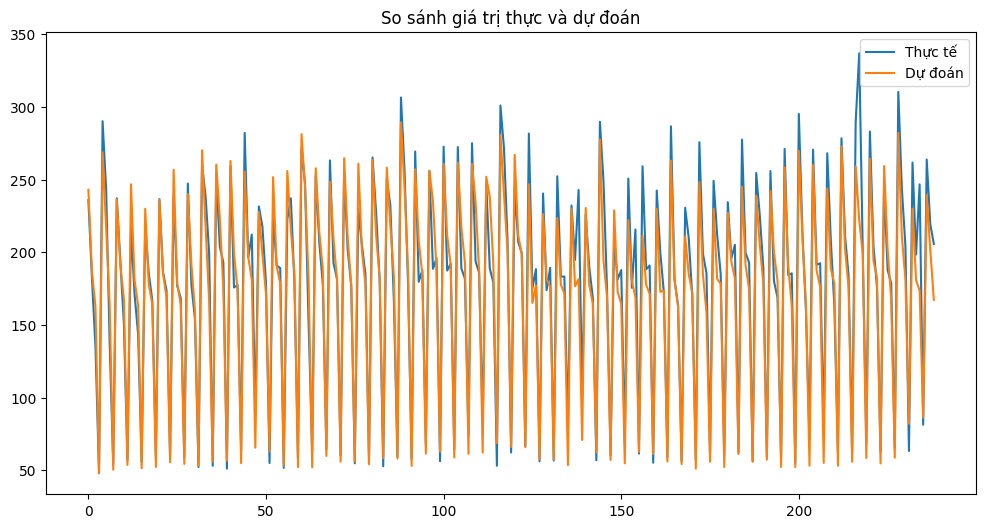

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Thực tế')
plt.plot(y_pred, label='Dự đoán')
plt.title('So sánh giá trị thực và dự đoán')
plt.legend()
plt.show()

In [ ]:
# Resample về 6h, lấy các thống kê chính
df =  result_df.copy()[['Timestamp','8401210607558_Flow']]

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

df_resampled = df.resample('6H').agg({
    '8401210607558_Flow': ['mean', 'max', 'min', 'std']  # Thêm các features tổng hợp
})


df_resampled.columns = ['flow_mean', 'flow_max', 'flow_min', 'flow_std']

# Tạo target: giá trị Flow tại thời điểm 6h + 15 phút sau
df_resampled['target_time'] = df_resampled.index + pd.Timedelta(hours=6, minutes=15)

# Merge với dữ liệu gốc để lấy giá trị target
df_final = df_resampled.merge(
    df[['8401210607558_Flow']].rename(columns={'8401210607558_Flow': 'target'}),
    left_on='target_time',
    right_index=True,
    how='inner'  # Chỉ giữ các mẫu có target tồn tại
)

<ipython-input-49-5b357439cbfe>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('6H').agg({


In [ ]:
  import pandas as pd
  import numpy as np
  from sklearn.preprocessing import StandardScaler
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import LSTM, Dense, Bidirectional
  from tensorflow.keras.callbacks import EarlyStopping

  # 1. Tiền xử lý dữ liệu
  df = result_df.copy()[['Timestamp','8401210607558_Flow']]
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])

  # df = pd.read_csv('data.csv', parse_dates=['Timestamp'], index_col='Timestamp')
  # Đặt Timestamp làm index
  df.set_index('Timestamp', inplace=True)
  df = df.interpolate(method='time')

  # Thêm features thời gian (tùy chọn tối ưu)
  df['hour'] = df.index.hour
  df['day_of_week'] = df.index.dayofweek

  # Chuẩn hóa dữ liệu
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(df)

  # 2. Tạo dữ liệu huấn luyện với cửa sổ trượt
  WINDOW_SIZE = 24  # 6 giờ = 24 timesteps (15 phút/timestep)

  def create_sequences(data, window_size):
      X, y = [], []
      for i in range(len(data) - window_size):
          X.append(data[i:i+window_size])
          y.append(data[i+window_size])
      return np.array(X), np.array(y)

  X, y = create_sequences(scaled_data, WINDOW_SIZE)

  # 3. Xây dựng mô hình LSTM
  model = Sequential([
      Bidirectional(LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, X.shape[2]))),
      Dense(X.shape[2])  # Dự đoán tất cả features
  ])
  model.compile(optimizer='adam', loss='mse')

  # 4. Chia dữ liệu và huấn luyện
  split_idx = int(0.8 * len(X))
  X_train, y_train = X[:split_idx], y[:split_idx]
  X_test, y_test = X[split_idx:], y[split_idx:]

  history = model.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_test, y_test),
                      shuffle=False,
                      callbacks=[EarlyStopping(patience=5)])

  # 5. Dự đoán timestep tiếp theo
  def predict_next_step(last_6h_data, model, scaler):
      scaled_input = scaler.transform(last_6h_data)
      input_sequence = scaled_input[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, -1)
      predicted_scaled = model.predict(input_sequence)
      return scaler.inverse_transform(predicted_scaled)[0]

  last_6h_data = df.iloc[-24:]  # Lấy 6 giờ cuối cùng
  prediction = predict_next_step(last_6h_data, model, scaler)
  print("Predicted values for next 15min:", prediction)

  # 6. Validation trên toàn bộ test set
  X_test_window = np.array([X_test[i] for i in range(len(X_test))])
  y_pred_scaled = model.predict(X_test_window)
  y_pred = scaler.inverse_transform(y_pred_scaled)
  actual = scaler.inverse_transform(y_test)

  # Đánh giá hiệu suất
  from sklearn.metrics import mean_absolute_error
  mae = mean_absolute_error(actual, y_pred)
  print(f"MAE on test set: {mae:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1189/1189 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - loss: 0.2735 - val_loss: 0.0624
Epoch 2/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.0965 - val_loss: 0.0620
Epoch 3/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - loss: 0.0892 - val_loss: 0.0539
Epoch 4/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 0.0855 - val_loss: 0.0510
Epoch 5/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.0822 - val_loss: 0.0513
Epoch 6/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0791 - val_loss: 0.0503
Epoch 7/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.0778 - val_loss: 0.0499
Epoch 8/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 0.0762 - val_loss: 0.0496
Epoch 9/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.0754 - val_loss: 0.0488
Epoch 10/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - loss: 0.0744 - val_loss: 0.0488
Epoch 11/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 0.0735 - val_loss: 0.0483
Epoch 12/50
1189/11

In [ ]:
errors = np.abs(actual - y_pred)

min_error = errors.min()
max_error = errors.max()

print(f"Min error: {min_error:.4f}")
print(f"Max error: {max_error:.4f}")

Min error: 0.0000
Max error: 568.5430


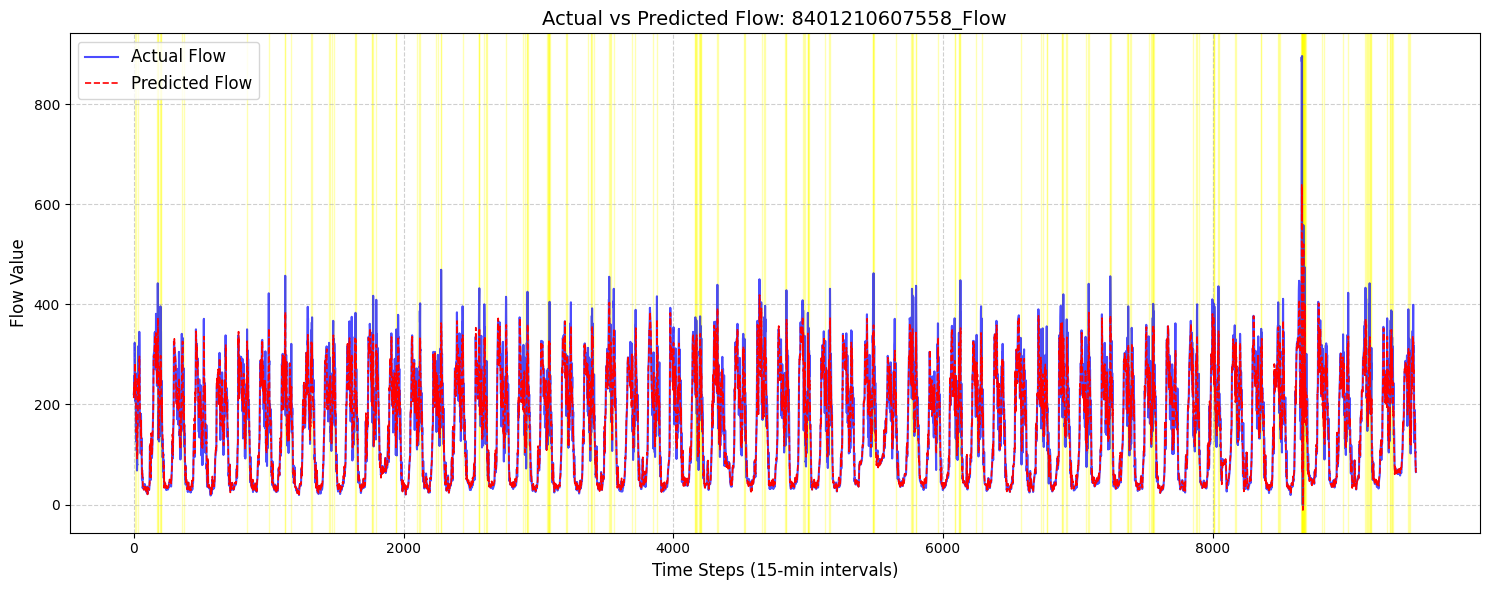

MAE for 8401210607558_Flow: 17.2591
Max Error: 568.5430


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_flow_prediction(actual, y_pred, df, flow_column_name='8401210607558_Flow'):
    try:
        # Tìm index của cột Flow
        flow_idx = list(df.columns).index(flow_column_name)

        plt.figure(figsize=(15, 6))

        # Vẽ đường thực tế và dự đoán
        plt.plot(actual[:, flow_idx], label='Actual Flow', color='blue', alpha=0.7, linewidth=1.5)
        plt.plot(y_pred[:, flow_idx], label='Predicted Flow', color='red', linestyle='--', linewidth=1.2)

        plt.title(f'Actual vs Predicted Flow: {flow_column_name}', fontsize=14)
        plt.xlabel('Time Steps (15-min intervals)', fontsize=12)
        plt.ylabel('Flow Value', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)

        # Highlight vùng sai số lớn
        errors = np.abs(actual[:, flow_idx] - y_pred[:, flow_idx])
        threshold = np.percentile(errors, 98)
        for i in range(len(errors)):
            if errors[i] > threshold:
                plt.axvspan(i-0.5, i+0.5, color='yellow', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Tính toán metrics
        mae = np.mean(errors)
        max_error = np.max(errors)
        print(f"MAE for {flow_column_name}: {mae:.4f}")
        print(f"Max Error: {max_error:.4f}")

        # # Vẽ scatter plot
        # plt.figure(figsize=(8, 8))
        # plt.scatter(actual[:, flow_idx], y_pred[:, flow_idx], alpha=0.5, color='green')
        # plt.plot([actual[:, flow_idx].min(), actual[:, flow_idx].max()],
        #          [actual[:, flow_idx].min(), actual[:, flow_idx].max()],
        #          'k--', lw=2)
        # plt.xlabel('Actual Flow', fontsize=12)
        # plt.ylabel('Predicted Flow', fontsize=12)
        # plt.title(f'Scatter Plot: {flow_column_name}', fontsize=14)
        # plt.grid(True, linestyle='--', alpha=0.6)
        # plt.show()

        return flow_idx

    except ValueError:
        print(f"Error: Column '{flow_column_name}' not found in dataframe columns")
        return None

flow_idx = visualize_flow_prediction(actual, y_pred, df)

In [ ]:
worst_case = np.argmax(np.abs(actual[:, flow_idx] - y_pred[:, flow_idx]))
print("Thời điểm dự đoán tệ nhất:", df.index[split_idx + WINDOW_SIZE + worst_case])

Thời điểm dự đoán tệ nhất: 2024-12-26 12:00:00+00:00
